In [124]:
import pickle
import pathlib

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

Obtendo os dados e processando categóricas.

In [125]:
DATA_DIR = pathlib.Path.cwd().parent / 'data'
print(DATA_DIR)
clean_data_path = DATA_DIR / 'processed' / 'ames_clean.pkl'
with open(clean_data_path, 'rb') as file:
    data = pickle.load(file)

/Users/femcdias/Documents/Insper/Semestre 4/Machine Learning/Projeto1/ames/data


In [126]:
model_data = data.copy()

Funções para análise de dados

In [127]:
def nonNull_percent(label, null_value = 0 ):
    f = model_data[label] != null_value
    return (model_data[label][f].value_counts().sum()/model_data[label].shape[0] *100)

def heatMapCorr(labels):
    correlation_matrix = model_data[labels + ["SalePrice"]].corr()

    # Create the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
    plt.title('Correlation Heatmap')
    plt.show()

Copia do processamento feito no notebook 03

In [128]:
model_data = data.copy()
categorical_columns = []
ordinal_columns = []
for col in model_data.select_dtypes('category').columns:
    if model_data[col].cat.ordered:
        ordinal_columns.append(col)
    else:
        categorical_columns.append(col)
for col in ordinal_columns:
    codes, _ = pd.factorize(data[col], sort=True)
    model_data[col] = codes
original_data = model_data['Exterior']
encoded_data = pd.get_dummies(original_data)

aux_dataframe = encoded_data
aux_dataframe['Exterior'] = original_data.copy()

aux_dataframe.head().transpose()
original_data = model_data['Exterior']
encoded_data = pd.get_dummies(original_data, drop_first=True)

aux_dataframe = encoded_data
aux_dataframe['Exterior'] = original_data.copy()

aux_dataframe.head().transpose()
model_data = pd.get_dummies(model_data, drop_first=True)
model_data.info()
for cat in categorical_columns:
    dummies = []
    for col in model_data.columns:
        if col.startswith(cat + "_"):
            dummies.append(f'"{col}"')
    dummies_str = ', '.join(dummies)
    print(f'From column "{cat}" we made {dummies_str}\n')

<class 'pandas.core.frame.DataFrame'>
Index: 2877 entries, 0 to 2929
Columns: 165 entries, Lot.Frontage to Exterior_Other
dtypes: bool(119), float64(34), int64(12)
memory usage: 1.4 MB
From column "MS.SubClass" we made "MS.SubClass_30", "MS.SubClass_50", "MS.SubClass_60", "MS.SubClass_70", "MS.SubClass_80", "MS.SubClass_85", "MS.SubClass_90", "MS.SubClass_120", "MS.SubClass_160", "MS.SubClass_190", "MS.SubClass_Other"

From column "MS.Zoning" we made "MS.Zoning_RH", "MS.Zoning_RL", "MS.Zoning_RM"

From column "Land.Contour" we made "Land.Contour_HLS", "Land.Contour_Low", "Land.Contour_Lvl"

From column "Lot.Config" we made "Lot.Config_CulDSac", "Lot.Config_FR2", "Lot.Config_FR3", "Lot.Config_Inside"

From column "Neighborhood" we made "Neighborhood_BrDale", "Neighborhood_BrkSide", "Neighborhood_ClearCr", "Neighborhood_CollgCr", "Neighborhood_Crawfor", "Neighborhood_Edwards", "Neighborhood_Gilbert", "Neighborhood_IDOTRR", "Neighborhood_MeadowV", "Neighborhood_Mitchel", "Neighborhood_NAm

Feature Engineering

Abrindo dados como histogramas para checar distribuição.

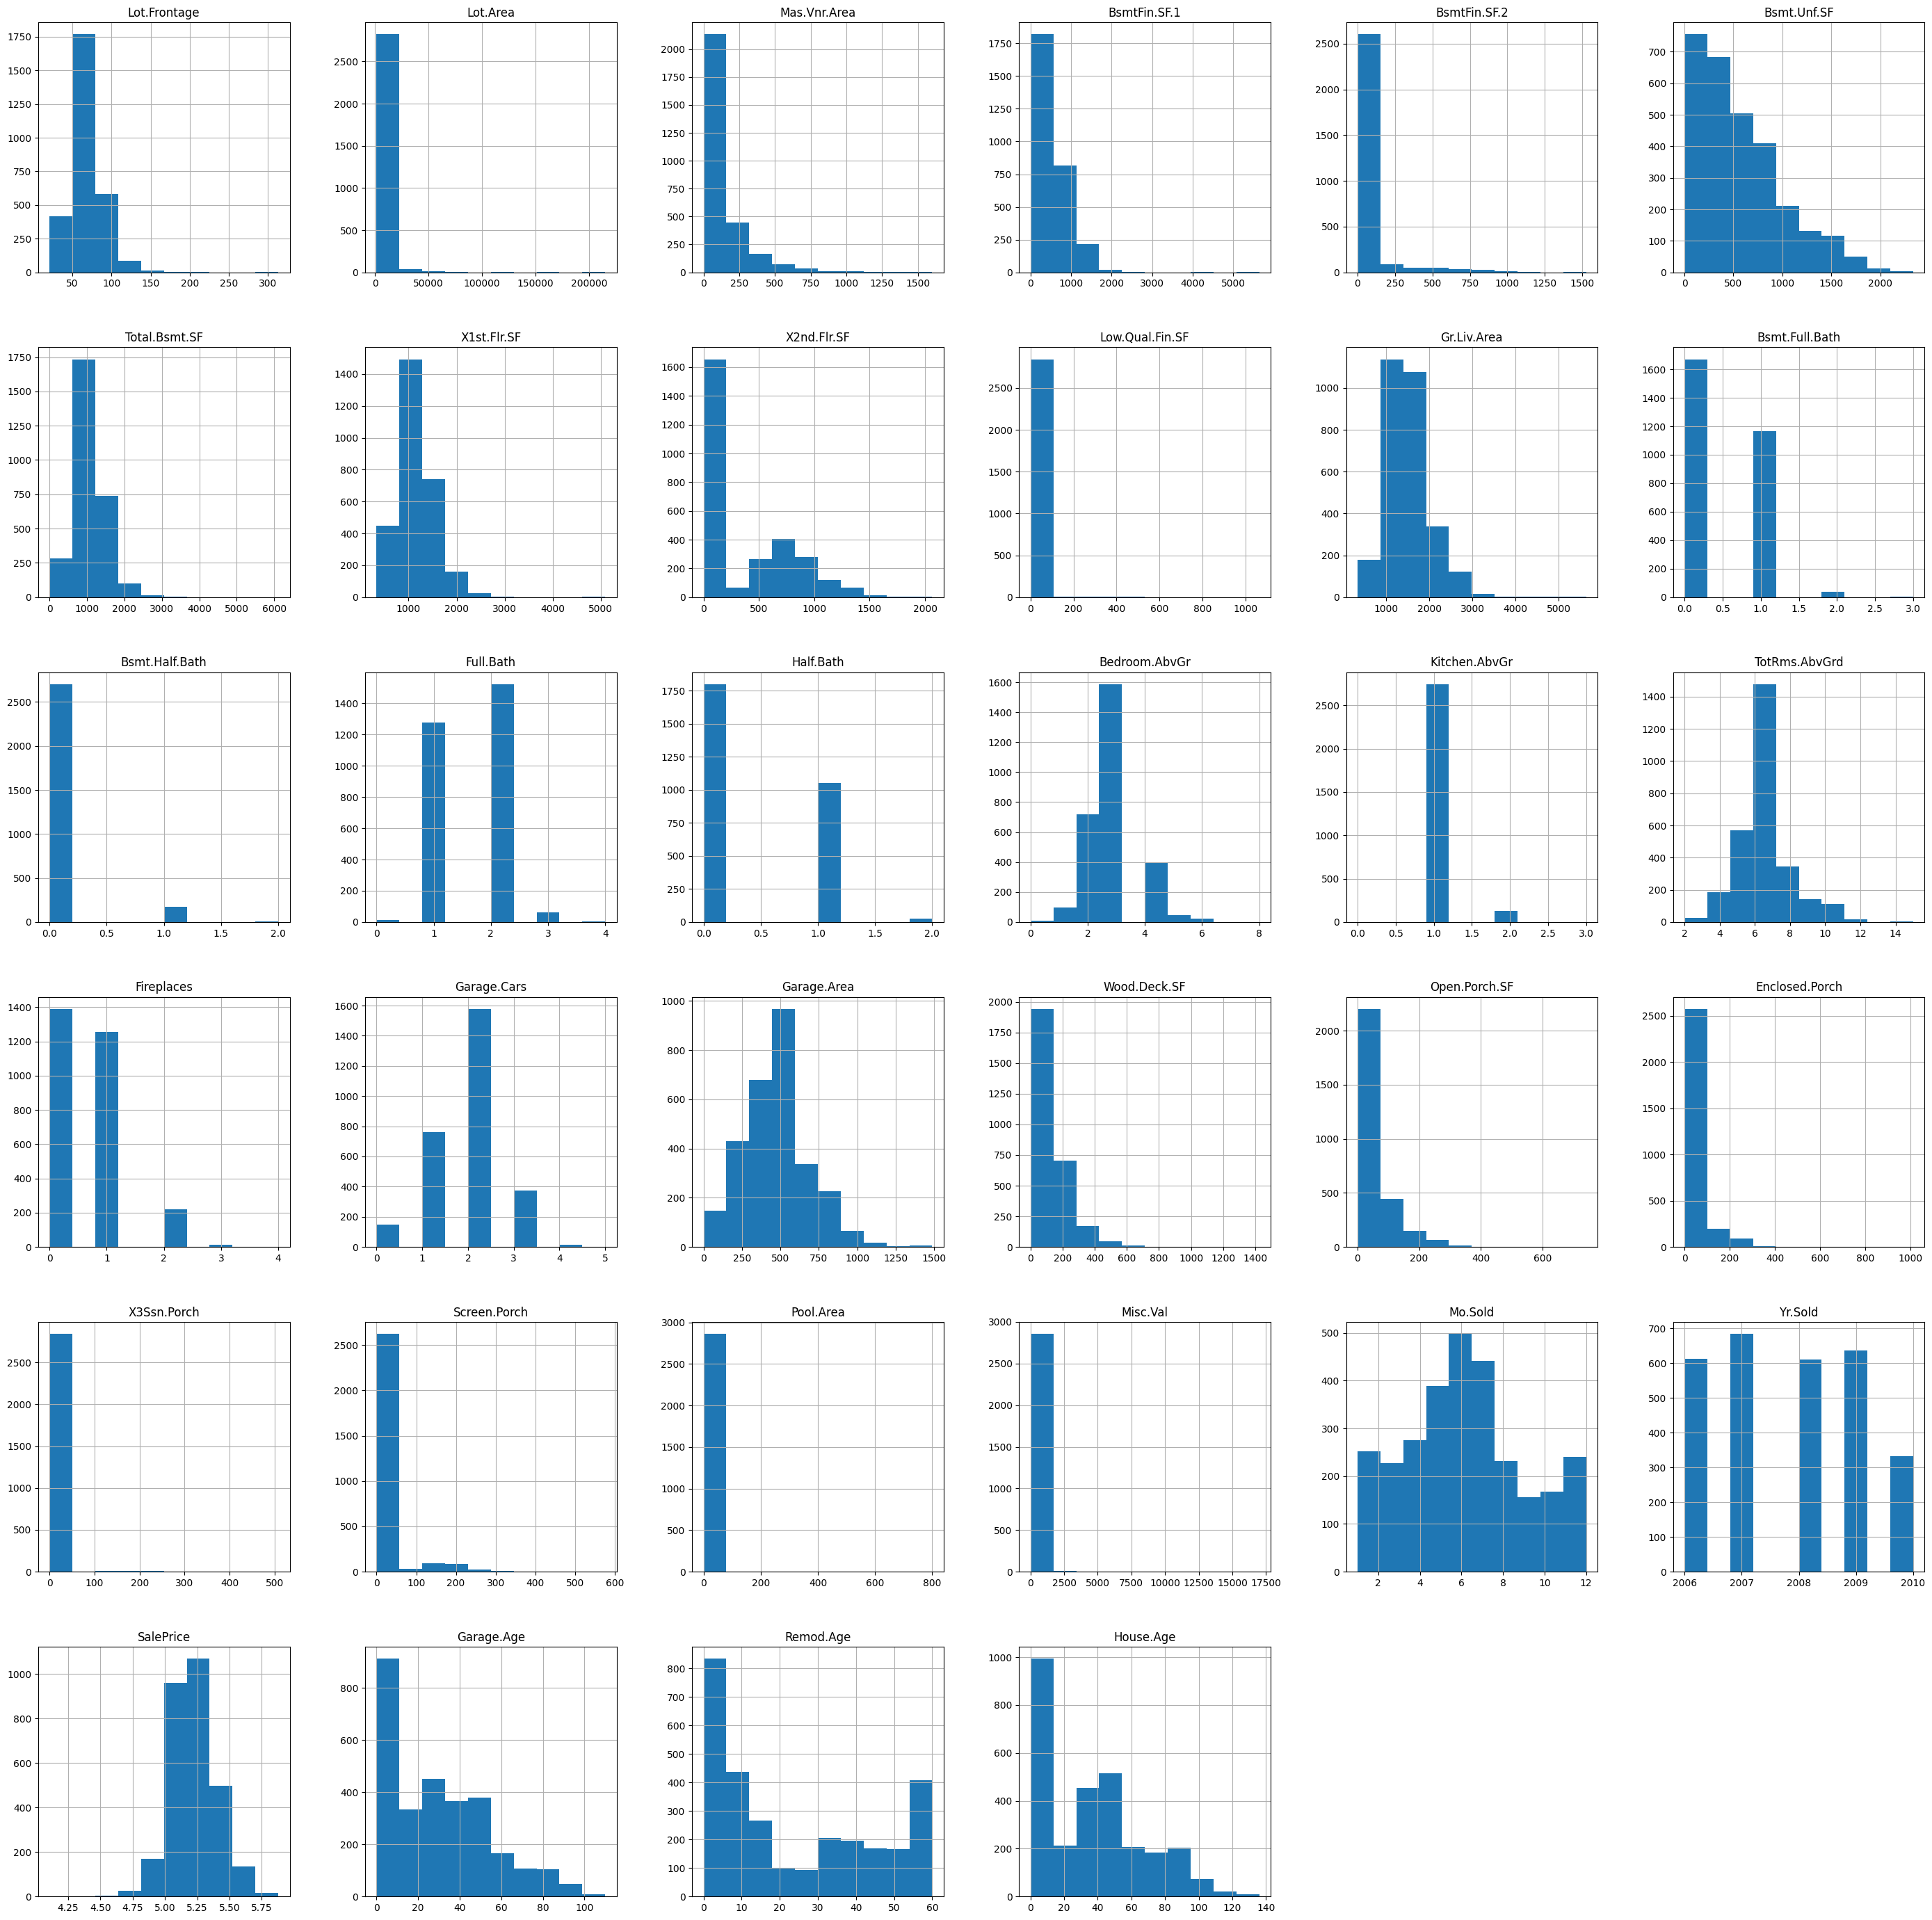

In [129]:
data.hist(figsize=(35,35))
print()

Primeiro, checarei variáveis relacionadas ao Lote da casa

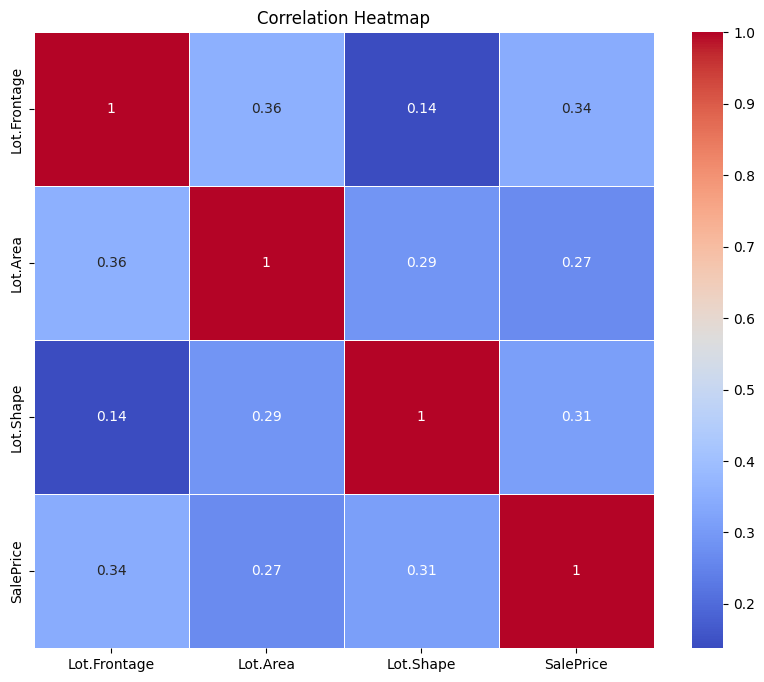

In [130]:
lot_cat = ["Lot.Frontage","Lot.Area","Lot.Shape"]
heatMapCorr(lot_cat)

Todas aparentam ter boa correlação individual com o target, então vamos analisar suas distribuições em busca de melhor representar nossos dados.

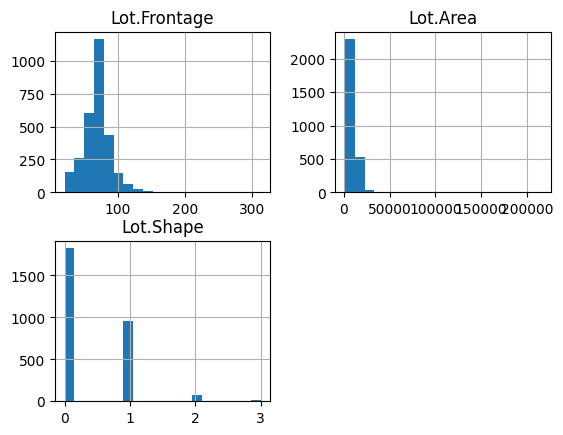

In [131]:
model_data[lot_cat].hist(bins=20)
print()

Pelo formato do gráfico, podemos perceber que os dados de "Lot.Area" tem uma grande quantidade de dados proximos ao zero e conforme a area cresce, a concentração de dados diminui - aplicar uma transformação para log fará nossos dados se tornarem mais legíveis e menos exparsos, mantendo sua propriedade e relevância.

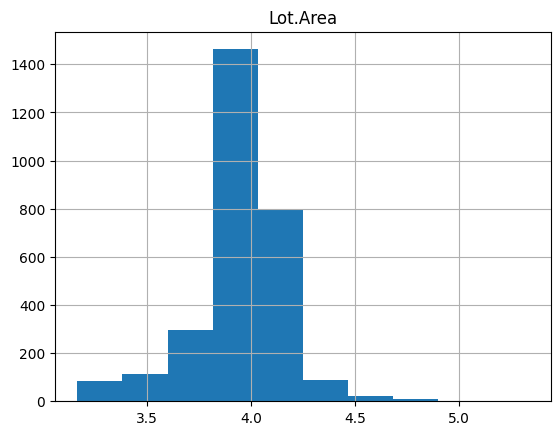

In [132]:
# seems like lot area might use some logs
pd.DataFrame(np.log10(data["Lot.Area"])).hist()
print()

OBS: Daqui para frente, dados com esse formato serão armazenados para serem transformados de uma vez só.

0.446062177443733
40.25026068821689


/var/folders/4z/6l2f7mfn2sj_wp6mbb6wr0n80000gn/T/ipykernel_73472/2681816740.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(model_data[["Mas.Vnr.Area","SalePrice"]].corr()["SalePrice"][0]) # high correlation...


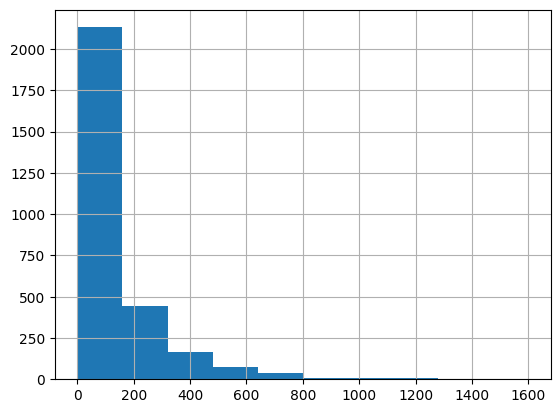

In [133]:
print(model_data[["Mas.Vnr.Area","SalePrice"]].corr()["SalePrice"][0]) # high correlation...
model_data["Mas.Vnr.Area"].hist()
print(nonNull_percent("Mas.Vnr.Area")) # has a good non-null amount...
right_skewed = ["Mas.Vnr.Area"]

In [134]:
# data["Mas.Vnr.Area"] = np.log1p(data["Mas.Vnr.Area"])
# data["Mas.Vnr.Area"].hist(bins=20)

Analysing Exter attributes

Essas features delimitam uma avaliação/ordem crescente e avaliam dados da mesma área, então criar uma feature generalizada pode nos ajudar a remover redundancia dos dados.

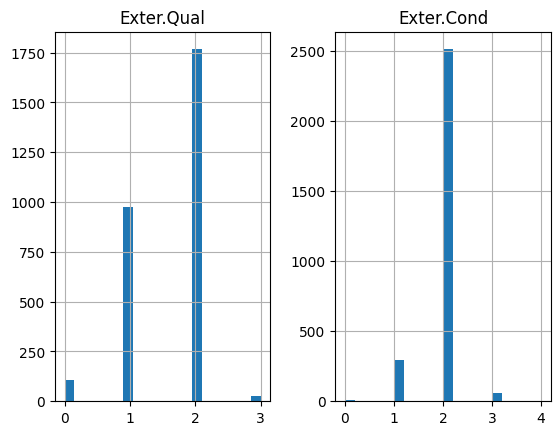

In [135]:
# External features
exter_cat = ["Exter.Qual","Exter.Cond"]
model_data[exter_cat].hist(bins=20) # these seem to reflect a more umbalanced rating
print()

Além disso, podemos verificar atráves dos histogramas que a feature criada tem comportamento similar ao de seus componentes e melhora a distribuição dos dados.

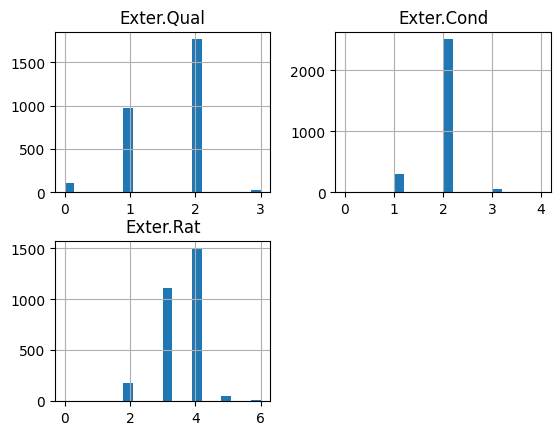

In [136]:
model_data["Exter.Rat"] = model_data["Exter.Qual"] + model_data["Exter.Cond"]
model_data[exter_cat+["Exter.Rat"]].hist(bins=20)
model_data = model_data.drop(columns=exter_cat)

Dados de Área do Porão

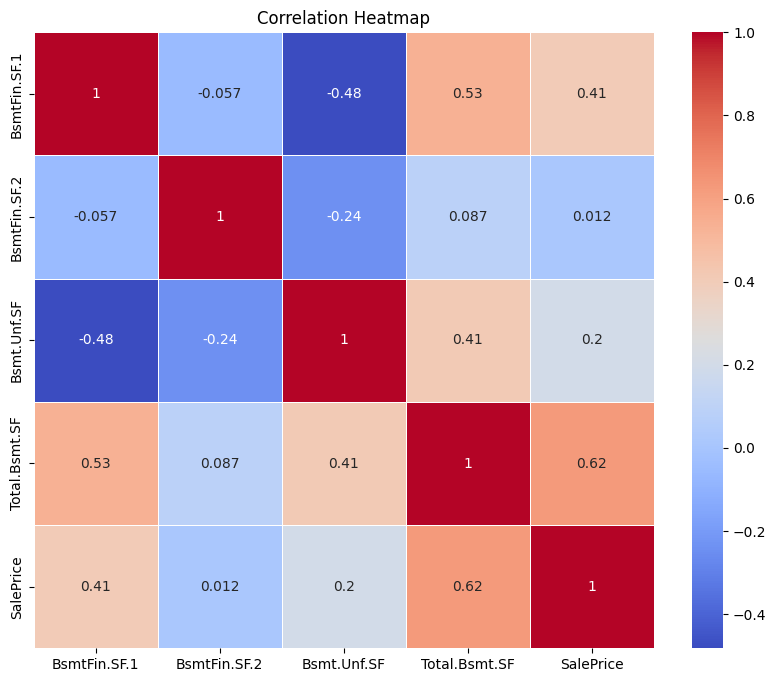

In [137]:
# Basement Features (Area)
basement_cat = ["BsmtFin.SF.1","BsmtFin.SF.2", "Bsmt.Unf.SF","Total.Bsmt.SF"]
heatMapCorr(basement_cat) # checking relevance...

BsmtFin.SF.1 68.57838025721237
BsmtFin.SF.2 12.02641640597845
Bsmt.Unf.SF 91.83176920403197
Total.Bsmt.SF 97.46263468891206


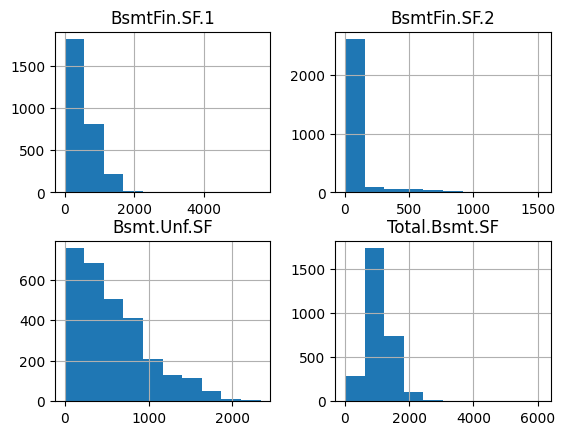

In [138]:
model_data[basement_cat].hist()
for cat in basement_cat:
    print(cat, nonNull_percent(cat))
    
right_skewed += ["BsmtFin.SF.1","BsmtFin.SF.2", "Bsmt.Unf.SF"]

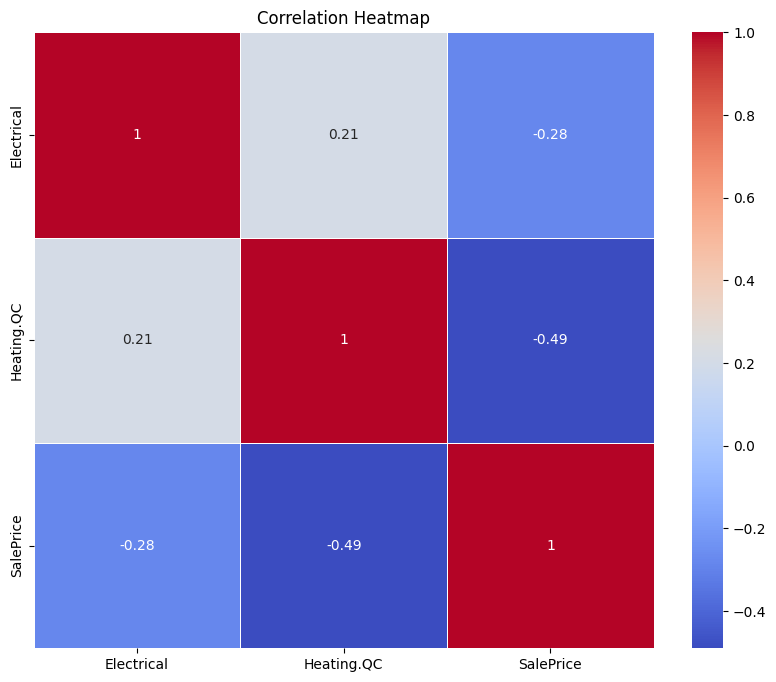

8.168230795968022
48.348974626346894


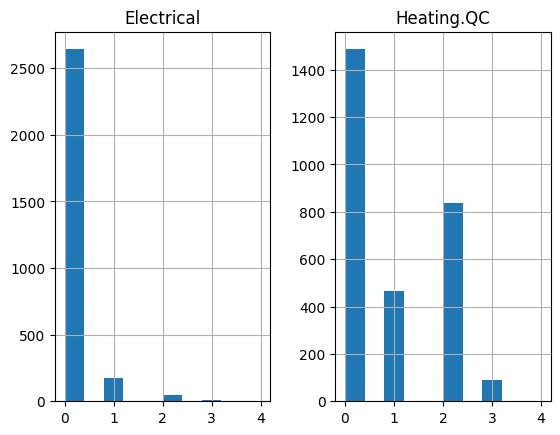

In [139]:
# Heating and Eletrical categories
he_cat = ["Electrical","Heating.QC"]
heatMapCorr(he_cat)  # seems relevant enough
model_data[he_cat].hist()
print(nonNull_percent(he_cat[0]))
print(nonNull_percent(he_cat[1]))

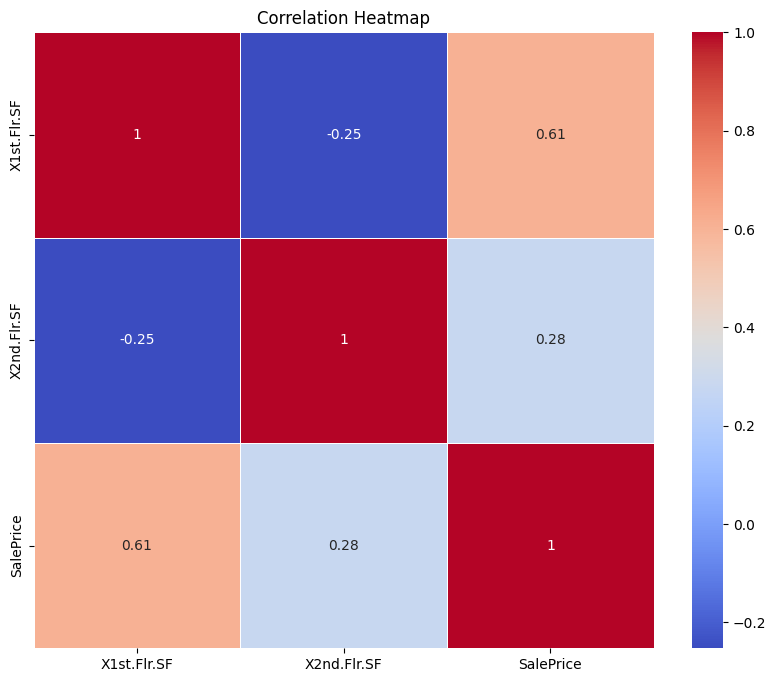

100.0
42.75286757038582


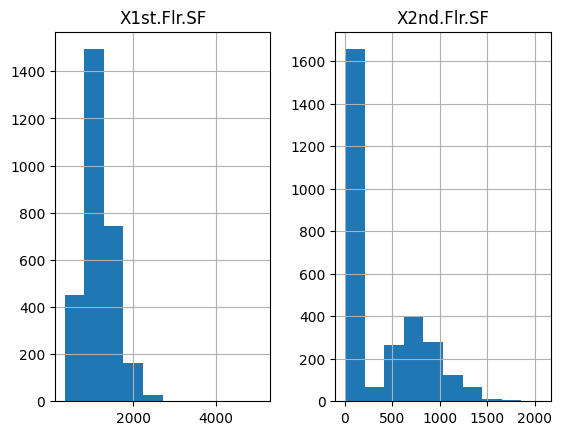

In [140]:
# xcat features
xcat = ["X1st.Flr.SF","X2nd.Flr.SF"] 
heatMapCorr(xcat)
model_data[xcat].hist()
print(nonNull_percent(xcat[0]))
print(nonNull_percent(xcat[1]))
# No worries it seems, still, what is it?
right_skewed.append(xcat[1])

In [141]:
model_data[["Low.Qual.Fin.SF","SalePrice"]].corr()["SalePrice"][0]
nonNull_percent("Low.Qual.Fin.SF")

/var/folders/4z/6l2f7mfn2sj_wp6mbb6wr0n80000gn/T/ipykernel_73472/3587964300.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model_data[["Low.Qual.Fin.SF","SalePrice"]].corr()["SalePrice"][0]


1.3555787278415017

Com as informações de "Gr.Liv.Area" e o numero total de quartos, podemos obter o tamanho médio de cada cômodo da casa, o que será um delimitador importante, visto que pondera varias medidas muito correlatas ao target, podendo ajudar a distiguir entre elas.

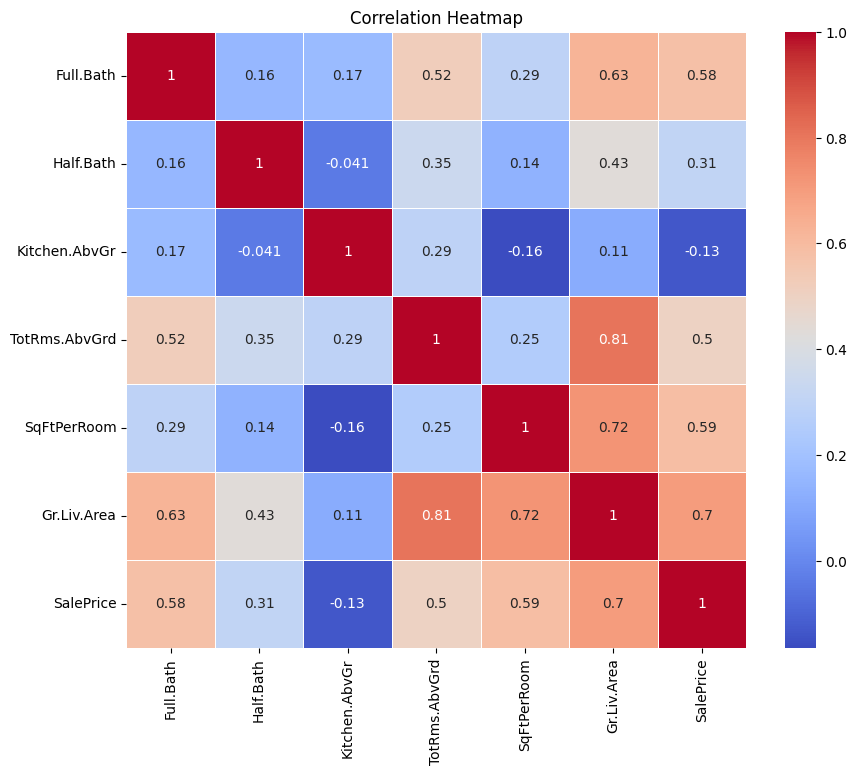

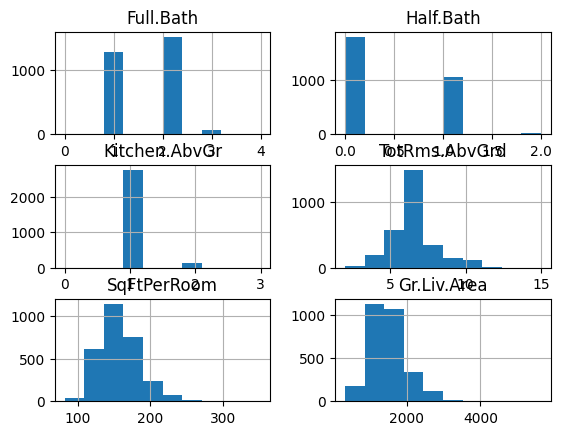

In [142]:
rooms = ["Full.Bath","Half.Bath", "Kitchen.AbvGr", "TotRms.AbvGrd"]
model_data["SqFtPerRoom"] =  model_data["Gr.Liv.Area"] / (model_data["TotRms.AbvGrd"] +
                                                       model_data["Full.Bath"] +
                                                       model_data["Half.Bath"] +
                                                       model_data["Kitchen.AbvGr"])
heatMapCorr(rooms+["SqFtPerRoom","Gr.Liv.Area"])
model_data[rooms + ["SqFtPerRoom","Gr.Liv.Area"]].hist()
print()

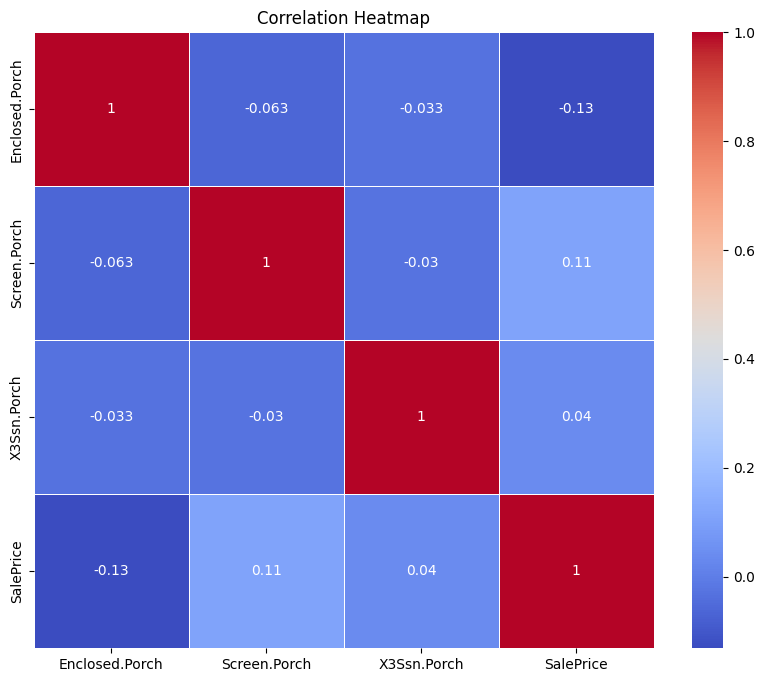

15.363225582203684
8.86339937434828
1.251303441084463


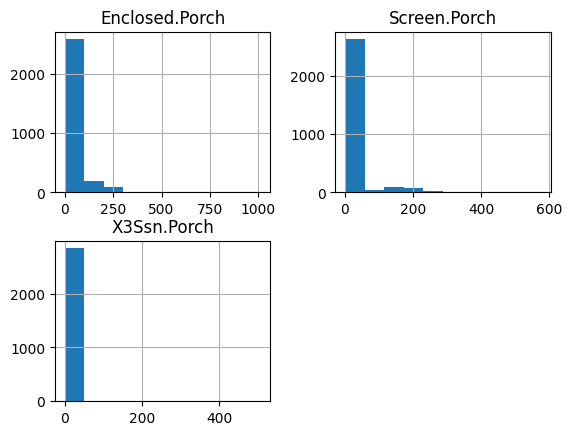

In [143]:
# Porch Features
porch_cat = ["Enclosed.Porch", "Screen.Porch", "X3Ssn.Porch"]
heatMapCorr(porch_cat)
model_data[porch_cat].hist()

for cat in porch_cat:
    print(nonNull_percent(cat))

In [144]:
# model_data = model_data.drop(columns=["Pool.Area","Misc.Val"])

array([[<Axes: title={'center': 'Mas.Vnr.Area'}>,
        <Axes: title={'center': 'BsmtFin.SF.1'}>],
       [<Axes: title={'center': 'BsmtFin.SF.2'}>,
        <Axes: title={'center': 'Bsmt.Unf.SF'}>],
       [<Axes: title={'center': 'X2nd.Flr.SF'}>, <Axes: >]], dtype=object)

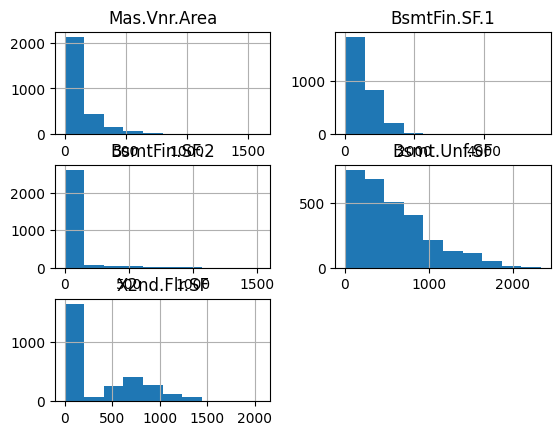

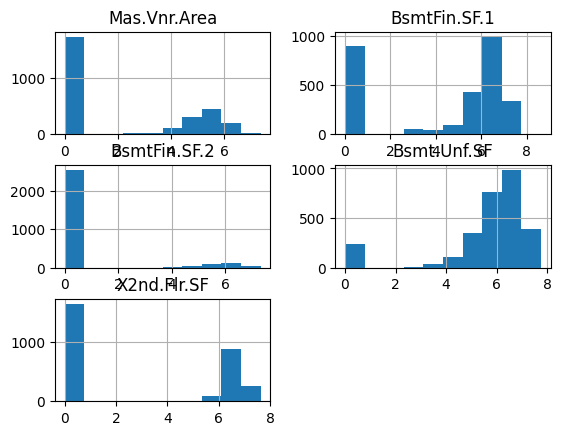

In [145]:
model_data[right_skewed].hist()
model_data[right_skewed] = np.log1p(model_data[right_skewed])
model_data[right_skewed].hist()

In [146]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [147]:
y = model_data["SalePrice"].copy()
X = model_data.drop(columns=["SalePrice"]).copy()
        
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.25,random_state=12,)
error_percent = {"LinearRegression":0,"Ridge":0,"Lasso":0}

In [148]:
piped_linear = Pipeline([
    ("Polynomial",PolynomialFeatures()),
    ("Scaler", StandardScaler()),
    ("Linear", LinearRegression()),
])

param_grid_linear = {
    'Polynomial__degree': [0,1,2],
}

grid_search_linear = GridSearchCV(piped_linear, param_grid_linear, 
                              cv=5, scoring="neg_mean_squared_error")

grid_search_linear.fit(Xtrain,ytrain)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Polynomial', PolynomialFeatures()),
                                       ('Scaler', StandardScaler()),
                                       ('Linear', LinearRegression())]),
             param_grid={'Polynomial__degree': [0, 1, 2]},
             scoring='neg_mean_squared_error')

In [149]:
print(f'melhores parametros para Linear Regression: {grid_search_linear.best_params_}')
score_linear = cross_val_score(grid_search_linear.best_estimator_,Xtrain,ytrain, scoring="neg_mean_squared_error")
score_linear = np.sqrt(-score_linear)
print(f'RMSE: {list(score_linear)}')
error_percent_linear = 100 * (10**score_linear - 1)

error_percent["LinearRegression"] = error_percent_linear
print(f'erro percentual: {list(error_percent["LinearRegression"])}')

melhores parametros para Linear Regression: {'Polynomial__degree': 0}
RMSE: [0.165713118458037, 0.18035322296263231, 0.17169509155849005, 0.1707859092467859, 0.17962224099284665]
erro percentual: [46.45800649234633, 51.479276778899454, 48.489276624255375, 48.178743990843806, 51.224529157979305]


In [150]:
piped_ridge = Pipeline([
    ("Polynomial",PolynomialFeatures()),
    ("Scaler", StandardScaler()),
    ("Ridge", Ridge())
])

param_grid_ridge = {
    'Ridge__alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
    'Polynomial__degree': [0,1,2],
}

grid_search_ridge = GridSearchCV(piped_ridge, param_grid_ridge, 
                              cv=5, scoring="neg_mean_squared_error")

grid_search_ridge.fit(Xtrain,ytrain)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Polynomial', PolynomialFeatures()),
                                       ('Scaler', StandardScaler()),
                                       ('Ridge', Ridge())]),
             param_grid={'Polynomial__degree': [0, 1, 2],
                         'Ridge__alpha': [0.001, 0.01, 0.1, 1.0, 10.0]},
             scoring='neg_mean_squared_error')

In [151]:
print(f'melhores parametros para Ridge Regression: {grid_search_ridge.best_params_}')
score_ridge = cross_val_score(grid_search_ridge.best_estimator_,Xtrain,ytrain, scoring="neg_mean_squared_error")
score_ridge = np.sqrt(-score_ridge)
print(f'RMSE: {list(score_ridge)}')
error_percent_ridge = 100 * (10**score_ridge - 1)
error_percent["Ridge"] = error_percent_ridge
print(f'erro percentual: {list(error_percent["Ridge"])}')

melhores parametros para Ridge Regression: {'Polynomial__degree': 1, 'Ridge__alpha': 10.0}
RMSE: [0.04583836574905789, 0.07222259101799192, 0.05717306540138151, 0.050211999701842036, 0.052996769461220165]
erro percentual: [11.131804371506316, 18.092574606209723, 14.070426515631617, 12.256629834408162, 12.978751061496862]


In [152]:
piped_lasso = Pipeline([
    ("Polynomial",PolynomialFeatures()),
    ("Scaler", StandardScaler()),
    ("Lasso", Lasso())
])

param_grid_lasso = {
    'Lasso__alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
    'Polynomial__degree': [0,1,2],
}

grid_search_lasso = GridSearchCV(piped_lasso, param_grid_lasso, 
                              cv=5, scoring="neg_mean_squared_error")

grid_search_lasso.fit(Xtrain,ytrain)

/Users/femcdias/Documents/Insper/Semestre 4/Machine Learning/Projeto1/ames/env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.949e-03, tolerance: 5.317e-03
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Polynomial', PolynomialFeatures()),
                                       ('Scaler', StandardScaler()),
                                       ('Lasso', Lasso())]),
             param_grid={'Lasso__alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
                         'Polynomial__degree': [0, 1, 2]},
             scoring='neg_mean_squared_error')

In [153]:
print(f'melhores parametros para Lasso Regression: {grid_search_lasso.best_params_}')
score_lasso = cross_val_score(grid_search_lasso.best_estimator_,Xtrain,ytrain, scoring="neg_mean_squared_error")
score_lasso = np.sqrt(-score_lasso)
print(f'RMSE: {list(score_lasso)}')
error_percent_lasso = 100 * (10**score_lasso - 1)
error_percent["Lasso"] = error_percent_lasso
print(f'erro percentual: {list(error_percent["Lasso"])}')

melhores parametros para Lasso Regression: {'Lasso__alpha': 0.001, 'Polynomial__degree': 1}
RMSE: [0.04441015129541211, 0.07272801192381902, 0.05848303445272846, 0.04793626971184063, 0.05458922137230865]
erro percentual: [10.766938227663525, 18.230087751751213, 14.41501831561347, 11.669936636518807, 13.39377701286475]


In [154]:
from scipy.stats import ttest_ind



ttest_ind(error_percent_ridge, error_percent_lasso, equal_var=False)

TtestResult(statistic=0.006158787092926563, pvalue=0.9952378707918947, df=7.944555200988745)

In [155]:
import xgboost as xgb

# Os melhores parametros do XGB foram obtidos com o GridSearchCV no notebook 06_xgboost_regression_modeling.ipynb
XGB = xgb.XGBRegressor(colsample_bytree=0.7, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.7, seed=42)

XGB.fit(Xtrain,ytrain)

/Users/femcdias/Documents/Insper/Semestre 4/Machine Learning/Projeto1/ames/env/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/femcdias/Documents/Insper/Semestre 4/Machine Learning/Projeto1/ames/env/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/femcdias/Documents/Insper/Semestre 4/Machine Learning/Projeto1/ames/env/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/femcdias/Documents/Insper/Semestre 4/Machine Learning/Projeto1/ames/env/

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [157]:
score_xgb = cross_val_score(XGB,Xtrain,ytrain, scoring="neg_mean_squared_error")
score_xgb = np.sqrt(-score_xgb)
print(f'RMSE: {list(score_xgb)}')
error_percent_xgb = 100 * (10**score_xgb - 1)
error_percent["XGBoost"] = error_percent_xgb
print(f'erro percentual: {list(error_percent["XGBoost"])}')

/Users/femcdias/Documents/Insper/Semestre 4/Machine Learning/Projeto1/ames/env/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/femcdias/Documents/Insper/Semestre 4/Machine Learning/Projeto1/ames/env/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/femcdias/Documents/Insper/Semestre 4/Machine Learning/Projeto1/ames/env/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/femcdias/Documents/Insper/Semestre 4/Machine Learning/Projeto1/ames/env/

RMSE: [0.04708254863238374, 0.0532656557113753, 0.05034800723880404, 0.05095975116126278, 0.058698746706187056]
erro percentual: [11.450635353441928, 13.048721646157135, 12.291790628084808, 12.450075448282693, 14.471861892678263]


/Users/femcdias/Documents/Insper/Semestre 4/Machine Learning/Projeto1/ames/env/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/femcdias/Documents/Insper/Semestre 4/Machine Learning/Projeto1/ames/env/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/femcdias/Documents/Insper/Semestre 4/Machine Learning/Projeto1/ames/env/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/femcdias/Documents/Insper/Semestre 4/Machine Learning/Projeto1/ames/env/

In [158]:
import catboost as cb

# Os melhores parametros do CatBoost foram obtidos com o GridSearchCV no notebook 07_catboost_regression_modeling.ipynb
CB = cb.CatBoostRegressor(bagging_temperature=0, border_count=32, depth=6, iterations=4000, l2_leaf_reg=0.75, learning_rate=0.05, model_size_reg=0.5, od_wait=100, random_seed=42, random_strength=3)

CB.fit(Xtrain,ytrain)


0:	learn: 0.1679577	total: 4.64ms	remaining: 18.5s
1:	learn: 0.1630268	total: 6.62ms	remaining: 13.2s
2:	learn: 0.1575082	total: 8.4ms	remaining: 11.2s
3:	learn: 0.1525441	total: 10.2ms	remaining: 10.2s
4:	learn: 0.1480515	total: 12.1ms	remaining: 9.66s
5:	learn: 0.1438260	total: 13.9ms	remaining: 9.26s
6:	learn: 0.1392733	total: 15.8ms	remaining: 9.01s
7:	learn: 0.1355259	total: 17.6ms	remaining: 8.8s
8:	learn: 0.1319102	total: 19.5ms	remaining: 8.65s
9:	learn: 0.1287928	total: 21.6ms	remaining: 8.62s
10:	learn: 0.1255787	total: 23.6ms	remaining: 8.57s
11:	learn: 0.1221250	total: 25.9ms	remaining: 8.59s
12:	learn: 0.1192735	total: 28ms	remaining: 8.59s
13:	learn: 0.1165793	total: 30ms	remaining: 8.54s
14:	learn: 0.1135933	total: 31.9ms	remaining: 8.48s
15:	learn: 0.1109248	total: 34ms	remaining: 8.48s
16:	learn: 0.1083605	total: 35.9ms	remaining: 8.42s
17:	learn: 0.1057699	total: 38.4ms	remaining: 8.5s
18:	learn: 0.1035568	total: 40.4ms	remaining: 8.46s
19:	learn: 0.1013635	total: 42.

In [ ]:
score_cb = cross_val_score(CB,Xtrain,ytrain, scoring="neg_mean_squared_error")
score_cb = np.sqrt(-score_cb)
print(f'RMSE: {list(score_cb)}')
error_percent_cb = 100 * (10**score_cb - 1)
error_percent["CatBoost"] = error_percent_cb
print(f'erro percentual: {list(error_percent["CatBoost"])}')

0:	learn: 0.1696982	total: 2.44ms	remaining: 9.76s
1:	learn: 0.1647927	total: 4.21ms	remaining: 8.41s
2:	learn: 0.1603127	total: 5.23ms	remaining: 6.97s
3:	learn: 0.1556262	total: 6.8ms	remaining: 6.8s
4:	learn: 0.1511232	total: 8.5ms	remaining: 6.79s
5:	learn: 0.1471622	total: 10.3ms	remaining: 6.83s
6:	learn: 0.1435205	total: 12ms	remaining: 6.85s
7:	learn: 0.1395319	total: 13.7ms	remaining: 6.85s
8:	learn: 0.1357374	total: 15.8ms	remaining: 6.99s
9:	learn: 0.1323387	total: 17.5ms	remaining: 6.99s
10:	learn: 0.1286347	total: 19.3ms	remaining: 7s
11:	learn: 0.1251485	total: 21.1ms	remaining: 7s
12:	learn: 0.1221262	total: 22.8ms	remaining: 6.99s
13:	learn: 0.1190064	total: 24.7ms	remaining: 7.04s
14:	learn: 0.1162700	total: 26.5ms	remaining: 7.04s
15:	learn: 0.1135843	total: 28.3ms	remaining: 7.04s
16:	learn: 0.1105171	total: 30.1ms	remaining: 7.05s
17:	learn: 0.1079183	total: 31.7ms	remaining: 7.02s
18:	learn: 0.1057517	total: 33.6ms	remaining: 7.03s
19:	learn: 0.1034517	total: 35.4m

In [ ]:
# Best model
best_model = ''
best_average = 100
for key in error_percent.keys():
    print(f'{key} error percentual: {error_percent[key].mean()}')
    if error_percent[key].mean() < best_average:
        best_average = error_percent[key].mean()
        best_model = key
print(f'Best model: {best_model}')


LinearRegression error percentual: 49.16596660886485
Ridge error percentual: 13.706037277850536
Lasso error percentual: 13.695151588882354
XGB error percentual: 12.742616993728964
CB error percentual: 11.63150389378509
Best model: CB
